## Anomaly Computation

Global anomalies look at the entire dataset, local anomalies focus on neighborhoods, and cluster anomalies consider the multi-dimensional structure of the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sovai as sov

sov.token_auth(token="your_token")

### Multivariate Anomaly Detection - Accounting Factors

In [3]:
# Load ratios - takes around 
df_factors = sov.data("factors/accounting", purge_cache=True); df_factors.head()

profitability  value  solvency  cash_flow  illiquidity  \
ticker date                                                                 
A      1999-11-26         57.000  8.000    17.000     77.000       14.000   
       1999-12-03         56.000  8.000    12.000     77.000       14.000   
       1999-12-10         56.000  8.000    25.000     77.000       14.000   
       1999-12-17         56.000  8.000    10.000     77.000       14.000   
       1999-12-24         55.000  7.000    25.000     77.000       14.000   

                   momentum_long_term  momentum_medium_term  \
ticker date                                                   
A      1999-11-26              61.000                57.000   
       1999-12-03              61.000                57.000   
       1999-12-10              61.000                57.000   
       1999-12-17              61.000                57.000   
       1999-12-24              61.000                57.000   

                   short_term_reversal  price_volatility  dividend_yield  \
ticker date                                                                
A      1999-11-26               47.000            29.000          29.000   
       1999-12-03               16.000            29.000          29.000   
       1999-12-10               30.000            28.000          28.000   
       1999-12-17               20.000            11.000          11.000   
       1999-12-24               12.000            13.000          13.000   

                   earnings_consistency  small_size  low_growth  \
ticker date                                                       
A      1999-11-26                65.000       3.000      51.000   
       1999-12-03                65.000       3.000      51.000   
       1999-12-10                65.000       3.000      51.000   
       1999-12-17                65.000       3.000      51.000   
       1999-12-24                65.000       3.000      51.000   

                   low_equity_issuance  bounce_dip  accrual_growth  \
ticker date                                                          
A      1999-11-26                1.000      51.000          54.000   
       1999-12-03                1.000      51.000          54.000   
       1999-12-10                1.000      51.000          54.000   
       1999-12-17                1.000      51.000          54.000   
       1999-12-24                1.000      51.000          54.000   

                   low_depreciation_growth  current_liquidity  low_rnd  \
ticker date                                                              
A      1999-11-26                   45.000             97.000   74.000   
       1999-12-03                   45.000             96.000   74.000   
       1999-12-10                   45.000             96.000   74.000   
       1999-12-17                   45.000             96.000   74.000   
       1999-12-24                   45.000             96.000   74.000   

                   momentum  
ticker date                  
A      1999-11-26    60.000  
       1999-12-03    61.000  
       1999-12-10    61.000  
       1999-12-17    60.000  
       1999-12-24    61.000

#### Local, Global, and Cluster Scores (For NVDA)

I only want to look at the last **three years**, the data should be in **percentile format**

In [4]:
import pandas as pd

ticker = "TSLA"

df_last_3_years = df_factors.loc[(slice(None), slice(pd.Timestamp.now() - pd.DateOffset(years=3), None)), :]

df_last_3_years = df_last_3_years.percentile()

df_anomaly_scores = df_last_3_years.anomalies("scores",ticker)

Optimal k for global anomaly detection: 49
LOF scores shape: (7587,)
Isolation Forest scores shape: (7587,)


In [7]:
df_anomaly_scores

global_anomaly_score  local_anomaly_score  \
ticker date                                                    
AEM    2021-07-16                 0.336                0.672   
       2021-07-23                 0.473                0.691   
       2021-07-30                 0.498                0.804   
       2021-08-06                 0.570                0.603   
       2021-08-13                 0.534                0.613   
...                                 ...                  ...   
ZS     2024-06-07                 0.217                0.391   
       2024-06-14                 0.239                0.421   
       2024-06-21                 0.204                0.431   
       2024-06-28                 0.264                0.442   
       2024-07-05                 0.225                0.388   

                   clustered_anomaly_score  
ticker date                                 
AEM    2021-07-16                    0.610  
       2021-07-23                    0.974  
       2021-07-30                    0.942  
       2021-08-06                    1.000  
       2021-08-13                    0.991  
...                                    ...  
ZS     2024-06-07                    0.354  
       2024-06-14                    0.358  
       2024-06-21                    0.353  
       2024-06-28                    0.432  
       2024-07-05                    0.372  

[7587 rows x 3 columns]

Plotting for random tickers. Specify tickers to plot specific data.


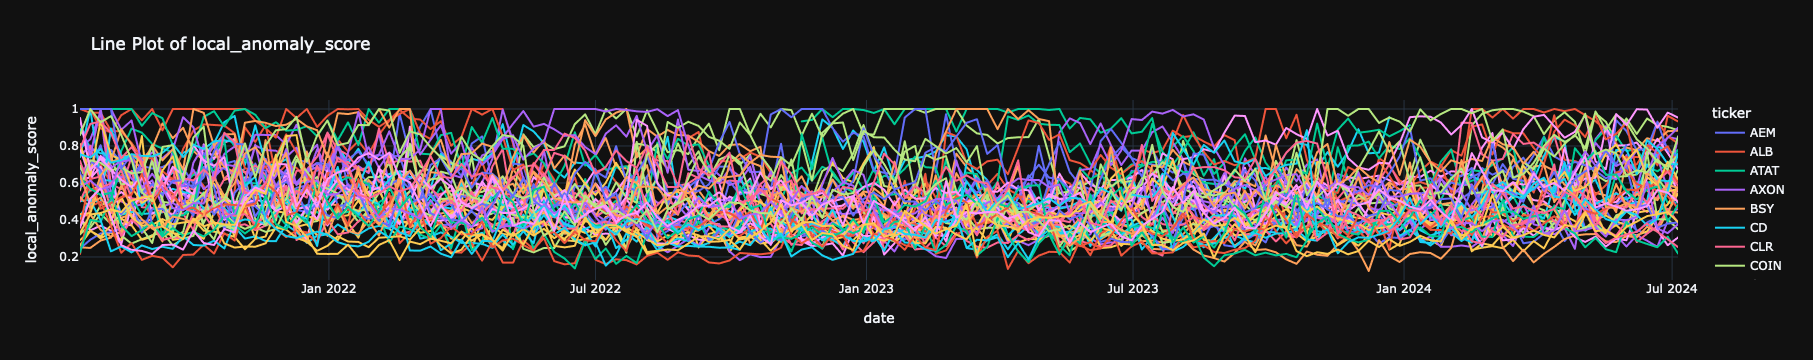

In [5]:
df_anomaly_scores.plot_line("local_anomaly_score", n=50)

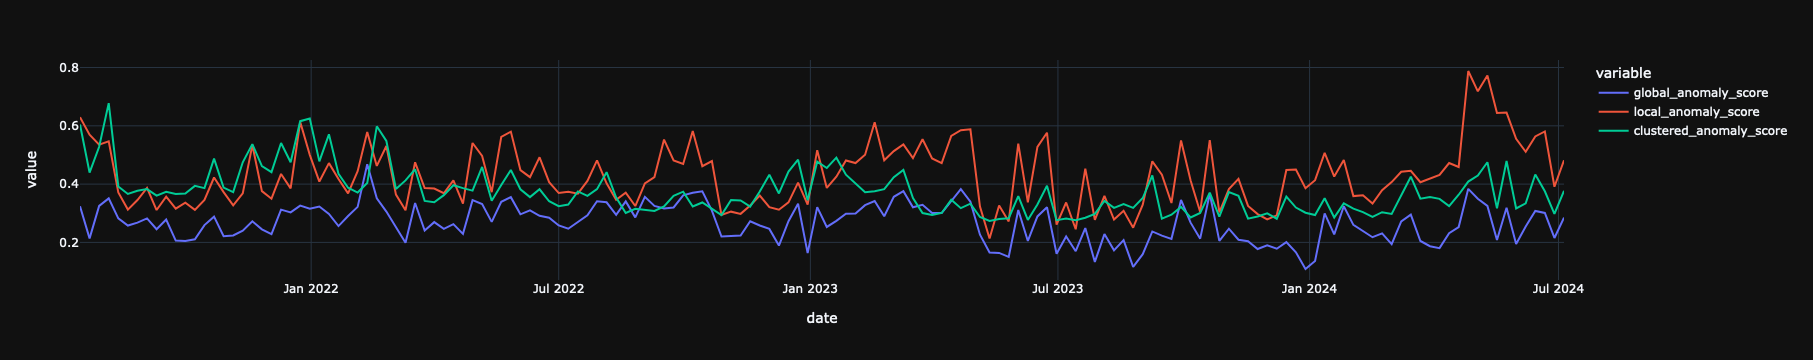

In [6]:
df_anomaly_scores.query("ticker ==@ticker").reset_index().set_index(["date"]).drop(columns=['ticker']).plot()

In [ ]:
import plotly.express as px

px.area(df_anomaly_scores.query("ticker == 'NVDA'").reset_index().set_index("date").drop(columns=['ticker']), title="NVDA Anomaly Scores Over Time", labels={"value": "Anomaly Score", "variable": "Feature"}, line_shape="spline").show()

In [ ]:
import plotly.express as px

px.bar(df_anomaly_scores.query("ticker == 'NVDA'").reset_index().melt(id_vars=['date', 'ticker'], var_name='Feature', value_name='Anomaly Score'), x='date', y='Anomaly Score', color='Feature', title="NVDA Anomaly Scores Over Time", barmode='stack').show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

def create_anomaly_dashboard(df_anomaly_scores, ticker):
    # Filter for the specific ticker and calculate percentile ranks
    df_ticker = df_anomaly_scores.loc[ticker].reset_index()
    df_all = df_anomaly_scores.reset_index()
    
    for score in ['global_anomaly_score', 'local_anomaly_score', 'clustered_anomaly_score']:
        df_ticker[f'{score}_percentile'] = df_ticker[score].rank(pct=True)
    
    # Calculate ratios and interactions
    for df in [df_ticker, df_all]:
        df['global_local_ratio'] = df['global_anomaly_score'] / df['local_anomaly_score']
        df['global_clustered_ratio'] = df['global_anomaly_score'] / df['clustered_anomaly_score']
        df['local_clustered_ratio'] = df['local_anomaly_score'] / df['clustered_anomaly_score']
        df['interaction_score'] = df['global_anomaly_score'] * df['local_anomaly_score'] * df['clustered_anomaly_score']
    
    # Create subplots
    fig = make_subplots(rows=3, cols=2, 
                        subplot_titles=('Anomaly Scores Over Time', 'Anomaly Score Percentiles',
                                        'Anomaly Score Ratios', 'Interaction Score',
                                        'Global vs Local Anomaly', 'Global vs Clustered Anomaly'))
    
    # Anomaly Scores Over Time
    for score, color in zip(['global_anomaly_score', 'local_anomaly_score', 'clustered_anomaly_score'], ['blue', 'red', 'green']):
        fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker[score], name=score.split('_')[0].capitalize(), line=dict(color=color)), row=1, col=1)
    
    # Anomaly Score Percentiles
    for score, color in zip(['global_anomaly_score', 'local_anomaly_score', 'clustered_anomaly_score'], ['blue', 'red', 'green']):
        fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker[f'{score}_percentile'], name=f'{score.split("_")[0].capitalize()} Percentile', line=dict(color=color)), row=1, col=2)
    
    # Anomaly Score Ratios
    for ratio, color in zip(['global_local_ratio', 'global_clustered_ratio', 'local_clustered_ratio'], ['purple', 'orange', 'brown']):
        fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker[ratio], name=ratio.replace('_', '/'), line=dict(color=color)), row=2, col=1)
    
    # Interaction Score
    fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker['interaction_score'], name='Interaction', line=dict(color='pink')), row=2, col=2)
    
    # Global vs Local Anomaly
    fig.add_trace(go.Scatter(x=df_all['global_anomaly_score'], y=df_all['local_anomaly_score'], mode='markers', name='All Tickers', marker=dict(color='lightgrey', size=5)), row=3, col=1)
    fig.add_trace(go.Scatter(x=df_ticker['global_anomaly_score'], y=df_ticker['local_anomaly_score'], mode='markers', name=ticker, marker=dict(color='red', size=8)), row=3, col=1)
    
    # Global vs Clustered Anomaly
    fig.add_trace(go.Scatter(x=df_all['global_anomaly_score'], y=df_all['clustered_anomaly_score'], mode='markers', name='All Tickers', marker=dict(color='lightgrey', size=5)), row=3, col=2)
    fig.add_trace(go.Scatter(x=df_ticker['global_anomaly_score'], y=df_ticker['clustered_anomaly_score'], mode='markers', name=ticker, marker=dict(color='red', size=8)), row=3, col=2)
    
    # Update layout
    fig.update_layout(height=1200, title_text=f"Anomaly Score Analysis Dashboard for {ticker}")
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=1, col=2)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=2)
    fig.update_xaxes(title_text="Global Anomaly Score", row=3, col=1)
    fig.update_xaxes(title_text="Global Anomaly Score", row=3, col=2)
    fig.update_yaxes(title_text="Anomaly Score", row=1, col=1)
    fig.update_yaxes(title_text="Percentile", row=1, col=2)
    fig.update_yaxes(title_text="Ratio", row=2, col=1)
    fig.update_yaxes(title_text="Interaction Score", row=2, col=2)
    fig.update_yaxes(title_text="Local Anomaly Score", row=3, col=1)
    fig.update_yaxes(title_text="Clustered Anomaly Score", row=3, col=2)
    
    return fig

# Usage
ticker = "NVDA"  # or any other ticker in your dataset
fig = create_anomaly_dashboard(df_anomaly_scores, ticker)
fig.show()

### Local, Global, and Cluster Anomalies (Feature-Level)

Here we can also analyse at a feature level what causes the anomalies for the security-date combinations.

In [14]:
def most_anomalous_features(df, ticker, years=3):
    """
    Identify and sort the most anomalous features for a given ticker.
    
    Parameters:
    df (DataFrame): The input DataFrame containing all data.
    ticker (str): The ticker symbol to analyze.
    years (int): The number of recent years to consider (default is 3).
    
    Returns:
    DataFrame: Sorted anomalous features for the latest date of the specified ticker.
    """
    # Get data for the last 3 years and calculate local anomalies

    # Filter data for the specified ticker
    ticker_data = df.query("ticker == @ticker")
    
    # Get the latest date
    max_date = ticker_data.index.max()
    
    # Get data for the latest date and transpose
    latest_data = ticker_data.query('index == @max_date').T
    
    # Sort the features based on their anomaly scores
    if latest_data.columns.nlevels > 1:
        # For multi-level columns
        first_column = latest_data.columns[0]
    else:
        # For single-level columns
        first_column = latest_data.columns[0]
    
    sorted_result = latest_data.sort_values(by=first_column, ascending=False)
    
    return sorted_result


In [8]:
# Local Most Anomalous Features
df_local = df_last_3_years.anomalies("local", ticker=ticker); df_local.head()

profitability  value  solvency  cash_flow  illiquidity  \
ticker date                                                                 
AEM    2021-07-16          0.721  0.489     0.792      0.738        0.429   
       2021-07-23          0.730  0.385     0.789      0.746        0.702   
       2021-07-30          0.673  0.424     0.792      0.736        0.845   
       2021-08-06          0.571  0.623     0.788      0.736        0.727   
       2021-08-13          0.383  0.790     0.669      0.365        0.469   

                   momentum_long_term  momentum_medium_term  \
ticker date                                                   
AEM    2021-07-16               0.813                 0.329   
       2021-07-23               0.497                 0.378   
       2021-07-30               0.524                 0.773   
       2021-08-06               0.577                 0.483   
       2021-08-13               0.680                 0.591   

                   short_term_reversal  price_volatility  dividend_yield  \
ticker date                                                                
AEM    2021-07-16                0.523             0.783           0.783   
       2021-07-23                0.302             0.795           0.795   
       2021-07-30                0.367             0.472           0.472   
       2021-08-06                0.319             0.353           0.353   
       2021-08-13                0.524             0.374           0.374   

                   earnings_consistency  small_size  low_growth  \
ticker date                                                       
AEM    2021-07-16                 0.418       0.758       0.980   
       2021-07-23                 0.746       0.748       0.785   
       2021-07-30                 0.280       0.421       0.680   
       2021-08-06                 0.300       0.412       0.678   
       2021-08-13                 0.384       0.415       0.700   

                   low_equity_issuance  bounce_dip  accrual_growth  \
ticker date                                                          
AEM    2021-07-16                0.662       0.361           0.328   
       2021-07-23                0.664       0.901           0.387   
       2021-07-30                0.676       0.690           0.274   
       2021-08-06                0.589       0.667           0.404   
       2021-08-13                0.448       0.669           0.331   

                   low_depreciation_growth  current_liquidity  low_rnd  \
ticker date                                                              
AEM    2021-07-16                    0.764              0.465    0.405   
       2021-07-23                    0.578              0.751    0.334   
       2021-07-30                    0.951              0.710    0.652   
       2021-08-06                    0.956              0.710    0.222   
       2021-08-13                    0.951              0.693    0.248   

                   momentum  anomaly_score  
ticker date                                 
AEM    2021-07-16     0.547          0.604  
       2021-07-23     0.472          0.624  
       2021-07-30     0.694          0.605  
       2021-08-06     0.781          0.562  
       2021-08-13     0.702          0.538

In [15]:
result = most_anomalous_features(df_local, ticker='NVDA'); result

ticker                        NVDA
date                    2024-07-05
small_size                   0.867
low_rnd                      0.861
low_equity_issuance          0.792
momentum_long_term           0.776
momentum                     0.700
low_growth                   0.665
cash_flow                    0.628
bounce_dip                   0.620
momentum_medium_term         0.610
earnings_consistency         0.577
anomaly_score                0.567
illiquidity                  0.520
value                        0.517
short_term_reversal          0.476
profitability                0.452
solvency                     0.452
current_liquidity            0.406
accrual_growth               0.382
low_depreciation_growth      0.353
dividend_yield               0.344
price_volatility             0.344

In [16]:
## Global Most Anomalous Features
df_global = df_last_3_years.anomalies("global", ticker=ticker); df_global.head()

profitability  value  solvency  cash_flow  illiquidity  \
ticker date                                                                 
AEM    2021-07-16          0.392  0.358     0.935      0.330        0.880   
       2021-07-23          0.565  0.421     0.591      0.335        0.597   
       2021-07-30          0.574  0.569     0.916      0.363        0.478   
       2021-08-06          0.459  0.540     0.334      0.419        0.529   
       2021-08-13          0.438  0.842     0.258      0.310        0.726   

                   momentum_long_term  momentum_medium_term  \
ticker date                                                   
AEM    2021-07-16               0.370                 0.906   
       2021-07-23               0.768                 0.330   
       2021-07-30               0.980                 0.658   
       2021-08-06               0.634                 0.669   
       2021-08-13               0.350                 0.720   

                   short_term_reversal  price_volatility  dividend_yield  \
ticker date                                                                
AEM    2021-07-16                0.654             0.342           0.342   
       2021-07-23                0.283             0.595           0.595   
       2021-07-30                0.488             0.402           0.402   
       2021-08-06                0.438             0.461           0.461   
       2021-08-13                0.802             0.256           0.256   

                   earnings_consistency  small_size  low_growth  \
ticker date                                                       
AEM    2021-07-16                 0.294       0.391       0.763   
       2021-07-23                 0.412       0.739       0.628   
       2021-07-30                 0.980       0.438       0.438   
       2021-08-06                 0.222       0.361       0.540   
       2021-08-13                 0.790       0.753       0.408   

                   low_equity_issuance  bounce_dip  accrual_growth  \
ticker date                                                          
AEM    2021-07-16                0.695       0.361           0.596   
       2021-07-23                0.333       0.354           0.428   
       2021-07-30                0.462       0.401           0.393   
       2021-08-06                0.746       0.454           0.633   
       2021-08-13                0.967       0.497           0.424   

                   low_depreciation_growth  current_liquidity  low_rnd  \
ticker date                                                              
AEM    2021-07-16                    0.203              0.591    0.454   
       2021-07-23                    0.905              0.172    0.979   
       2021-07-30                    0.690              0.517    0.451   
       2021-08-06                    0.686              0.452    0.344   
       2021-08-13                    0.675              0.652    0.195   

                   momentum  anomaly_score  
ticker date                                 
AEM    2021-07-16     0.364          0.511  
       2021-07-23     0.498          0.526  
       2021-07-30     0.614          0.561  
       2021-08-06     0.412          0.490  
       2021-08-13     0.642          0.548

In [17]:
result = most_anomalous_features(df_global, ticker='NVDA'); result

ticker                        NVDA
date                    2024-07-05
small_size                   0.978
cash_flow                    0.910
low_rnd                      0.881
earnings_consistency         0.813
low_depreciation_growth      0.772
momentum                     0.752
accrual_growth               0.720
solvency                     0.707
price_volatility             0.605
dividend_yield               0.605
anomaly_score                0.581
short_term_reversal          0.549
illiquidity                  0.491
momentum_long_term           0.430
momentum_medium_term         0.421
bounce_dip                   0.404
low_equity_issuance          0.366
profitability                0.350
low_growth                   0.347
current_liquidity            0.262
value                        0.254

In [ ]:
## Clustered Most Anomalous Features
df_cluster = df_last_3_years.anomalies("cluster", ticker=ticker); df_cluster.head()

In [19]:
result = most_anomalous_features(df_cluster, ticker='NVDA'); result

ticker                        NVDA
date                    2024-07-05
low_equity_issuance          0.391
small_size                   0.303
earnings_consistency         0.280
price_volatility             0.246
dividend_yield               0.246
illiquidity                  0.181
bounce_dip                   0.177
cash_flow                    0.156
outlier_score                0.145
momentum_long_term           0.124
solvency                     0.123
low_rnd                      0.114
momentum                     0.108
short_term_reversal          0.107
accrual_growth               0.101
momentum_medium_term         0.065
low_growth                   0.056
profitability                0.055
current_liquidity            0.035
value                        0.026
low_depreciation_growth      0.007

In [20]:
df_full = (df_local + df_global + df_cluster)/3

In [ ]:
result = most_anomalous_features(df_full, ticker='NVDA'); result

In [ ]:
df_full[[result.reset_index()["index"].values[0][0]]].query("ticker == @ticker").plot_line()

In [ ]:
df_last_3_years[[result.reset_index()["index"].values[0][0]]].query("ticker == @ticker").plot_line()

### Reconstruction Anomaly

The positive and negative reconstruction error can give us the direction of the anomaly

In [ ]:
df_recons = df_factors.anomalies("reconstruction", "TSLA")

In [ ]:
df_recons.head()